In [1]:
import numpy as np
import matplotlib
matplotlib.rcParams['figure.figsize'] = [4, 4]
import matplotlib.pyplot as plt

In [2]:
from math import inf
from timeit import default_timer as timer
import numpy as np


try:
    from genosolver import minimize, check_version
    USE_GENO_SOLVER = True
except ImportError:
    from scipy.optimize import minimize
    USE_GENO_SOLVER = False
    WRN = 'WARNING: GENO solver not installed. Using SciPy solver instead.\n' + \
          'Run:     pip install genosolver'
    print('*' * 63)
    print(WRN)
    print('*' * 63)

class GenoNLP:
    def __init__(self, W, y, c):
        self.W = W
        self.y = y
        self.c = c
        assert isinstance(W, np.ndarray)
        dim = W.shape
        assert len(dim) == 2
        self.W_rows = dim[0]
        self.W_cols = dim[1]
        assert isinstance(y, np.ndarray)
        dim = y.shape
        assert len(dim) == 1
        self.y_rows = dim[0]
        self.y_cols = 1
        assert isinstance(c, np.ndarray)
        dim = c.shape
        assert len(dim) == 1
        self.c_rows = dim[0]
        self.c_cols = 1
        self.x_rows = self.y_rows
        self.x_cols = 1
        self.x_size = self.x_rows * self.x_cols
        # the following dim assertions need to hold for this problem
        assert self.W_rows == self.y_rows == self.c_rows == self.x_rows == self.W_cols

    def getBounds(self):
        bounds = []
        bounds += [(-inf, inf)] * self.x_size
        return bounds

    def getStartingPoint(self):
        self.xInit = np.random.randn(self.x_rows, self.x_cols)
        return self.xInit.reshape(-1)

    def variables(self, _x):
        x = _x
        return x

    def fAndG(self, _x):
        x = self.variables(_x)
        t_0 = (x - self.y)
        f_ = (0.5 * (np.linalg.norm(t_0) ** 2))
        g_0 = t_0
        g_ = g_0
        return f_, g_

    def functionValueIneqConstraint000(self, _x):
        x = self.variables(_x)
        f = (((x - self.c)).dot((self.W).dot((x - self.c))) - 1)
        return f

    def gradientIneqConstraint000(self, _x):
        x = self.variables(_x)
        g_ = (((self.W).dot((x - self.c)) + (self.W.T).dot((x - self.c))))
        return g_

    def jacProdIneqConstraint000(self, _x, _v):
        x = self.variables(_x)
        gv_ = (((_v * (self.W).dot((x - self.c))) + (_v * (self.W.T).dot((x - self.c)))))
        return gv_

def toArray(v):
    return np.ascontiguousarray(v, dtype=np.float64).reshape(-1)

def solve(W, y, c):
    start = timer()
    NLP = GenoNLP(W, y, c)
    x0 = NLP.getStartingPoint()
    bnds = NLP.getBounds()
    tol = 1E-6
    # These are the standard GENO solver options, they can be omitted.
    options = {'tol' : tol,
               'constraintsTol' : 1E-4,
               'maxiter' : 1000,
               'verbosity' : 1  # Set it to 0 to fully mute it.
              }

    if USE_GENO_SOLVER:
        # Check if installed GENO solver version is sufficient.
        check_version('0.0.3')
        constraints = ({'type' : 'ineq',
                        'fun' : NLP.functionValueIneqConstraint000,
                        'jacprod' : NLP.jacProdIneqConstraint000})
        result = minimize(NLP.fAndG, x0,
                          bounds=bnds, options=options,
                          constraints=constraints)
    else:
        # SciPy: for inequality constraints need to change sign f(x) <= 0 -> f(x) >= 0
        constraints = ({'type' : 'ineq',
                        'fun' : lambda x: -NLP.functionValueIneqConstraint000(x),
                        'jac' : lambda x: -NLP.gradientIneqConstraint000(x)})
        result = minimize(NLP.fAndG, x0, jac=True, method='SLSQP',
                          bounds=bnds,
                          constraints=constraints)

    # assemble solution and map back to original problem
    x = result.x
    ineqConstraint000 = np.asarray(NLP.functionValueIneqConstraint000(x))
    ineqConstraint000[ineqConstraint000 < 0] = 0
    x = NLP.variables(x)
    solution = {}
    solution['success'] = result.success
    solution['message'] = result.message
    solution['fun'] = result.fun
    solution['grad'] = result.jac
    if USE_GENO_SOLVER:
        solution['slack'] = result.slack
    solution['x'] = x
    solution['ineqConstraint000'] = toArray(ineqConstraint000)
    solution['elapsed'] = timer() - start
    return solution

def generateRandomData():
    np.random.seed(0)
    W = np.random.randn(3, 3)
    y = np.random.randn(3)
    c = np.random.randn(3)
    return W, y, c

***************************************************************
Run:     pip install genosolver
***************************************************************


In [3]:
def get_circle(x,y,r):
    x_ = np.linspace(x-r,x+r,1000)
    x__ = np.hstack([x_,x_])
    y_ = np.sqrt(r**2 - (x_ - x)**2) + y
    y__ = np.hstack([y_,y-np.sqrt(r**2 - (x_ - x)**2)])
    xy = np.vstack([x__,y__])
    return xy

def plot_circle(x,y,r):
    xy = get_circle(x,y,r)
    plt.scatter(xy[0,:],xy[1,:], s=0.5, linewidth=0.1)

def set_lim(l):
    plt.xlim([-l,l])
    plt.ylim([-l,l])

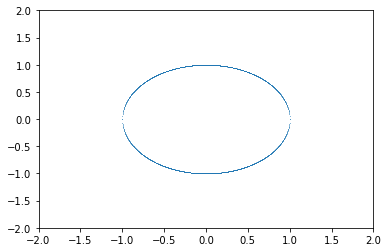

In [4]:
plot_circle(0,0,1)
set_lim(2)
plt.show()

[[1 0]
 [0 2]]


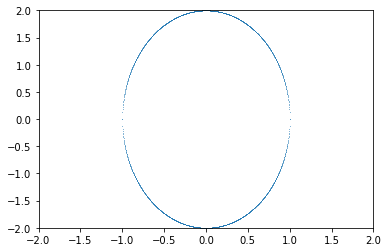

In [5]:
W = np.array([[1,0],[0,2]])
print(W)
xy = get_circle(0,0,1)
w_xy = W @ xy
plt.scatter(w_xy[0,:],w_xy[1,:], s=0.5, linewidth=0.1)
set_lim(2)
plt.show()

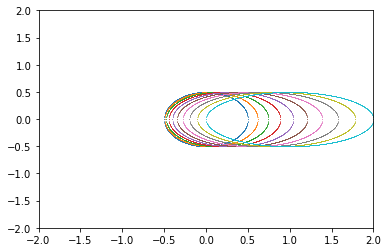

In [6]:
""" Now we simulate what happens when the diagonal depends on the weights, i.e. the position of the center"""
zeta_r = 0.5
zeta_c = 0.5
for l in np.linspace(0.0,1.0,10):
    x = l
    y = 0.0
    W = np.array([[zeta_r * abs(x) + zeta_c, 0],[0, zeta_r * abs(y) + zeta_c]])
    xy = get_circle(x,y,1.0)
    w_xy = W @ xy
    plt.scatter(w_xy[0,:],w_xy[1,:], s=0.5, linewidth=0.1)
set_lim(2)
plt.show()

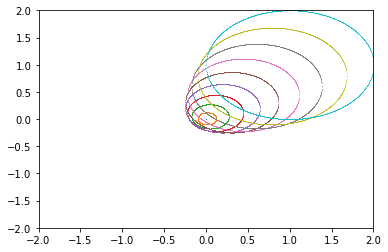

In [7]:
"""With small constant term"""
zeta_r = 1.0
zeta_c = 0.001
for l in np.linspace(0.0,1.0,10):
    x = l
    y = l
    W = np.array([[zeta_r * abs(x) + zeta_c, 0],[0, zeta_r * abs(y) + zeta_c]])
    xy = get_circle(x,y,1.0)
    w_xy = W @ xy
    plt.scatter(w_xy[0,:],w_xy[1,:], s=0.5, linewidth=0.1)
set_lim(2)
plt.show()

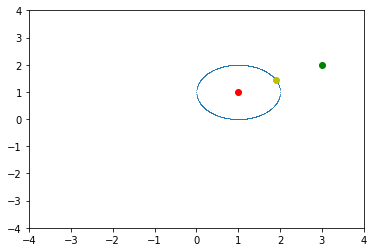

In [8]:
"""Projection on the epsilon ball"""
eps = 1.0
c = np.array([1.0,1.0]) # - Center of the ball
plot_circle(c[0],c[1],eps)
plt.scatter(c[0],c[1], color="r")
y = np.array([3,2])
plt.scatter(y[0],y[1], color="g")

"""
We are trying to project the greem dot onto the ball.
This corresponds to solving the following optimisation problem:

arg min_x .5||y-x||^2_2 s.t. ||x-c||^2_2 <= eps**2

The solution to this problem is given by: x* = c + eps/(max(||y-c||_2,eps))*(y-c)
"""

def proj_ball(c,eps,y):
    return c + eps/max(np.linalg.norm(y-c,ord=2),eps)*(y-c)

proj_y = proj_ball(c,eps,y)
plt.scatter(proj_y[0],proj_y[1], color="y")
set_lim(4)
plt.show()

1.0000000554397925


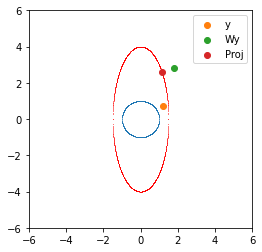

In [259]:
eps = 1
W = np.array([[1.5,0],[0,4]])
c = np.array([0.0,0.0])
xy = get_circle(c[0],c[1],1)
w_xy = W @ xy
y = np.array([np.sqrt(.5)+0.5,np.sqrt(.5)])
w_y = W @ y
plot_circle(c[0],c[1],eps)
plt.scatter(w_xy[0,:],w_xy[1,:], color="r", s=0.5, linewidth=0.1)
plt.scatter(y[0],y[1],label="y")
plt.scatter(w_y[0],w_y[1],color="C2",label="Wy")

solution = solve(np.linalg.inv(W)**2,w_y,c)
x_proj = solution["x"]
plt.scatter(x_proj[0],x_proj[1],color="C3",label="Proj")

print(np.dot((x_proj - c), np.linalg.inv(W)**2 @ (x_proj -c)))

set_lim(6)
plt.legend()
plt.show()


Point that lies within
0.3611111111111111
Point outside
7.111111111111111


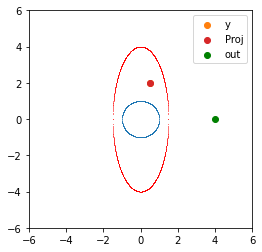

In [268]:
y = np.array([0.5,2])
plot_circle(c[0],c[1],eps)
plt.scatter(w_xy[0,:],w_xy[1,:], color="r", s=0.5, linewidth=0.1)
plt.scatter(y[0],y[1],label="y")
solution = solve(np.linalg.inv(W)**2,y,c)
x_proj = solution["x"]
plt.scatter(x_proj[0],x_proj[1],color="C3",label="Proj")

print("Point that lies within")
print(np.dot((y - c), np.linalg.inv(W)**2 @ (y -c)))
print("Point outside"); a = np.array([4,0])
print(np.dot((a - c), np.linalg.inv(W)**2 @ (a -c)))
plt.scatter(a[0],a[1], color="g", label="out")

set_lim(6)
plt.legend()
plt.show()